In [3]:
import cv2
import numpy as np
import copy
import math
# import pytesseract

from sklearn.cluster import KMeans
from skimage.segmentation import clear_border

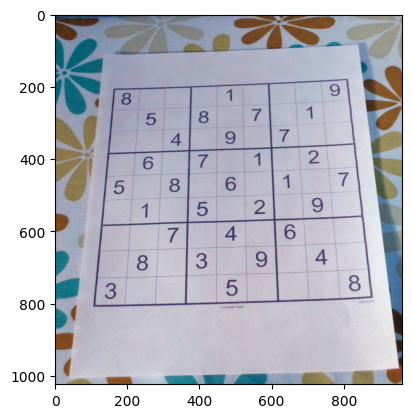

In [4]:
import matplotlib.pyplot as plt
img = cv2.imread("../DATA/sudoku.jpg")
# cv2.imshow(img)
plt.imshow(img)

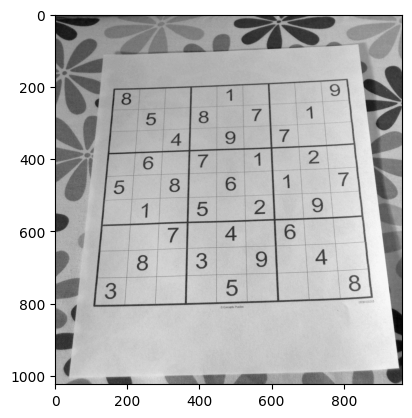

In [6]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
# gray = cv2.GaussianBlur(gray, (7, 7), 3)

# cv2.imshow('test',gray)
# cv2.waitKey(0)
plt.imshow(gray, cmap='gray')

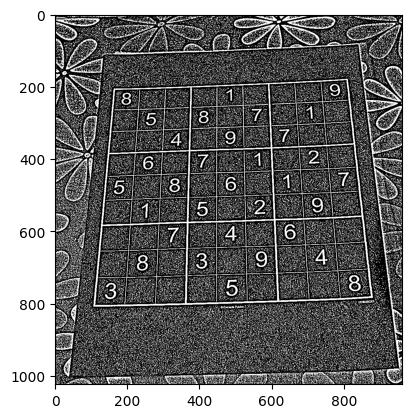

In [7]:
thresh = cv2.adaptiveThreshold(gray, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
thresh = cv2.bitwise_not(thresh)

# cv2_imshow(thresh)
plt.imshow(thresh, cmap='gray')

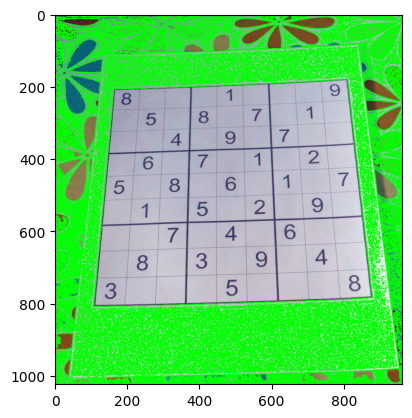

In [8]:

cnts,_ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

img_copy = img.copy()
# cv2.drawContours(img_copy, cnts, -1, (0, 255, 0), 2)
cv2.drawContours(img_copy, cnts, -1, (0, 255, 0), 2)

# cv2.imshow("Puzzle Thresh contours", img_copy)
# cv2.waitKey(0)
# cv2_imshow(img_copy)
plt.imshow(img_copy, cmap='gray')

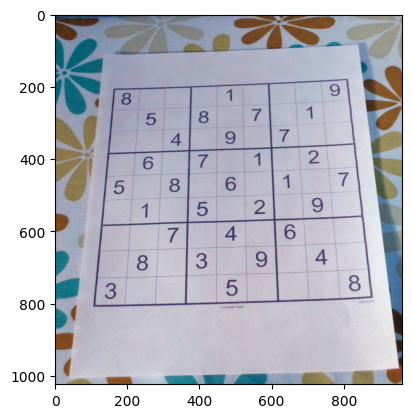

In [9]:
puzzleCnt = None
for c in cnts:

    approx = cv2.approxPolyDP(c, 15, True)

    if len(approx) == 4:
        puzzleCnt = approx
        break
img_copy = img.copy()
cv2.drawContours(thresh, [puzzleCnt], -1, (0, 255, 0), 2)
# cv2.imshow("Puzzle Outline", img)
# cv2.waitKey(0)
# cv2_imshow(img_copy)
plt.imshow(img_copy, cmap='gray')

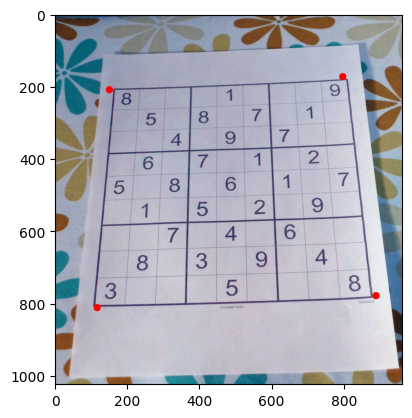

In [12]:
tl, bl, br, tr =  puzzleCnt[0][0], puzzleCnt[1][0], puzzleCnt[2][0], puzzleCnt[3][0]
points = [tl, tr, br, bl]

def expand_rect(tl, bl, br, tr):
    width = tr[0] - tl[0]
    height = bl[1] - tl[1]

    width_grow = 0.1*width
    height_grow = 0.1*height

    tl[0] = int(tl[0]-width_grow/2)
    tl[1] = int(tl[1]-height_grow/2)

    tr[0] = int(tr[0]+width_grow/2)
    tr[1] = int(tr[1]-height_grow/2)

    bl[0] = int(bl[0]-width_grow/2)
    bl[1] = int(bl[1]+height_grow/2)

    br[0] = int(br[0]+width_grow/2)
    br[1] = int(br[1]+height_grow/2)

    return tuple(tl), tuple(bl), tuple(br), tuple(tr)

tl, bl, br, tr = expand_rect(tl, bl, br, tr)

img_copy = img.copy()

cv2.circle(img_copy, tl, 10, (255,0,0),-1)
cv2.circle(img_copy, tr, 10, (255,0,0),-1)
cv2.circle(img_copy, bl, 10, (255,0,0),-1)
cv2.circle(img_copy, br, 10, (255,0,0),-1)
# cv2_imshow(img_copy)
plt.imshow(img_copy, cmap='gray')

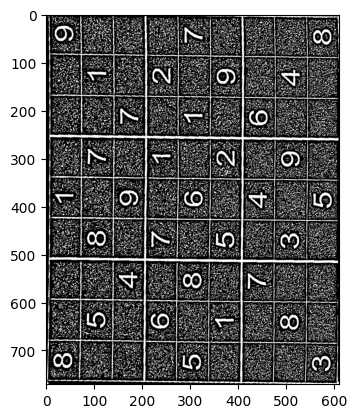

In [40]:
# compute the width of the new image, which will be the
# maximum distance between bottom-right and bottom-left
# x-coordiates or tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
w = max(int(widthA), int(widthB))

# compute the height of the new image, which will be the
# maximum distance between the top-right and bottom-right
# y-coordinates or the top-left and bottom-left y-coordinates
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
h = max(int(heightA), int(heightB))

src = np.array(points, dtype="float32")
dst = np.array([
        [0, 0],
        [w - 1, 0],
        [w - 1, h - 1],
        [0, h - 1]], dtype="float32")

img_copy_2 = img.copy()

# # Apply Perspective Transform Algorithm
matrix = cv2.getPerspectiveTransform(src, dst)
result = cv2.warpPerspective(thresh, matrix, (w, h))
# result = np.rot90(result)
# result = np.rot90(result)
# result = np.rot90(result)


# cv2_imshow(result)
plt.imshow(result, cmap='gray')

In [42]:
print(result.ndim) # выводит 2


2


In [43]:
cols, rows = result.shape

if cols%9 != 0:
    cols = cols+(9-cols%9)

if rows%9 != 0:
    rows = rows+(9-rows%9)

# result = np.resize(result, (new_cols, new_rows, channels))
result = cv2.resize(result,(rows,cols))

# Extract Cells

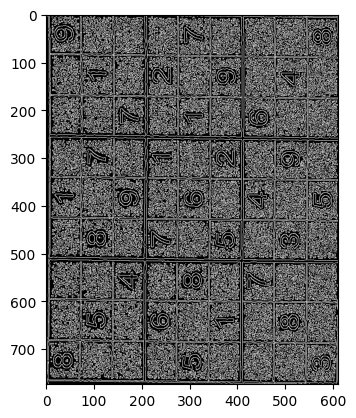

In [46]:
# Edge detection
result_edge = cv2.Canny(result, 50, 200, None, 3)

# cv2_imshow(result_edge)
plt.imshow(result_edge, cmap='gray')

In [49]:
horizontal_lines = []
vertical_lines = []

#  Standard Hough Line Transform
lines = cv2.HoughLines(result_edge, 1, np.pi / 180, 150, None, 0, 0)
result_copy = result.copy()
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(result_copy, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

        if lines[i][0][1] < np.pi/20 or lines[i][0][1] > np.pi-np.pi/20:
            cv2.line(result_copy, pt1, pt2, (0,255,0), 1, cv2.LINE_AA)
            vertical_lines.append((pt1,pt2))
        elif abs(lines[i][0][1]-np.pi/2)<np.pi/20:
            cv2.line(result_copy, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)
            horizontal_lines.append((pt1,pt2))

def intersection(line1,line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
    #    raise Exception('lines do not intersect')
        return False, None

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return True, (int(x), int(y))

intersection_pts = []

for line1 in vertical_lines:
    for line2 in horizontal_lines:
        inter, pt = intersection(line1,line2)
        if inter:
            intersection_pts.append(pt)
            cv2.circle(result_copy,pt,2,(255,0,0),1)

X = np.array(intersection_pts)
kmeans = KMeans(n_clusters=100, random_state=0).fit(X)
cluster_centers = kmeans.cluster_centers_

for center in cluster_centers:
    center = (int(center[0]), int(center[1]))
    cv2.circle(result_copy,center,4,(0,0,255),-1)

# cv2_imshow(result_copy)
plt.imshow(result_copy)

c:\Users\Nitro5\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


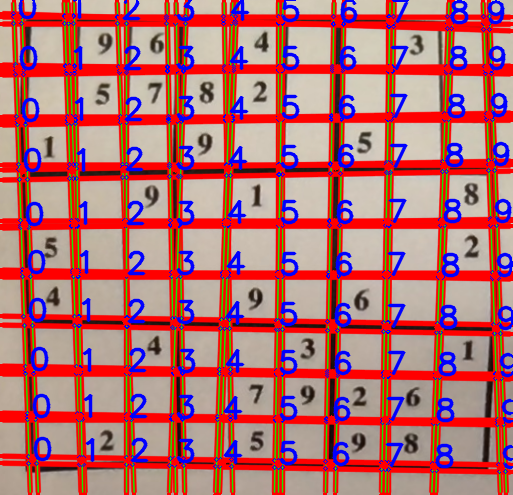

In [ ]:
def sorting_bounding_box(cluster_centers, num_rows=10):

    # Split in y direction first and then split in x
    # Assuming we know the number of rows.
    # top_left_corners = [(center[0], center[1]) for center in cluster_centers] #boxes
    cluster_centers_ys = np.array([np.array(pt[1]) for pt in cluster_centers])
    
    # Do the clustering
    kmeans = KMeans(n_clusters=num_rows, random_state=0).fit(cluster_centers_ys.reshape(-1, 1))
    
    # Split as rows based on clusters
    rows = {}
    for i, label in enumerate(kmeans.labels_):
        if label not in rows:
            rows[label] = []

        # create a dict with row (cluster label) as key and boxes as value
        rows[label].append((int(cluster_centers[i][0]),int(cluster_centers[i][1])))

    # print(rows)

    # Sort columns within rows based on x coordinate
    for row in rows:
        rows[row] = sorted(rows[row], key=lambda x: x[0])

    # Sort rows based on y coordinate of first box's top-left point
    # We get a list of tuples (key,value)
    row_sorted_list = sorted(rows.items(), key=lambda x: x[1][0][1])

    # Create a new dictionary with the sorted row order as key and the corresponding sorted boxes as value
    sorted_rows_and_columns = {}
    for i,item in enumerate(row_sorted_list):
        sorted_rows_and_columns[i] = item[1]

    return sorted_rows_and_columns

sorted_rows_and_columns = sorting_bounding_box(cluster_centers, num_rows=10)

for row in sorted_rows_and_columns:
    for i,pt in enumerate(sorted_rows_and_columns[row]):
        cv2.putText(result_copy, str(i),pt,cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0),2,cv2.LINE_AA)

cv2_imshow(result_copy)

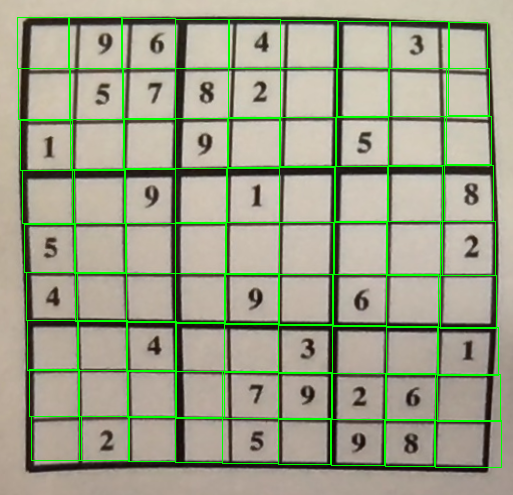

In [ ]:
result_copy = result.copy()
cells = {}
cell_points = {}
for row in sorted_rows_and_columns:
    if row>8:
        break
    if row not in cells:
        cells[row] = []
        cell_points[row] = []
    for i, pt1 in enumerate(sorted_rows_and_columns[row]):
        if i>8:
            break
        row_2 = sorted_rows_and_columns[row+1]
        pt2 = row_2[i+1]
        
        cropped_cell = result[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        cell_points[row].append([(pt1,pt2),0])

        cells[row].append(cropped_cell.copy())
        cv2.rectangle(result_copy, pt1, pt2, (0,255,0),1)

cv2_imshow(result_copy)

In [ ]:
!sudo add-apt-repository ppa:alex-p/tesseract-ocr-devel
!sudo apt-get install tesseract-ocr
# !pip install pytesseract
!pip install pytesseract==0.3.8
!sudo apt-get update

 This PPA contains an OCR engine - libtesseract and a command line program - tesseract. The development version available here (currntly 5.0.0 ) is better in many aspects (functionality, speed, stability) but is not 100 % API compatible with version 4.0. Tesseract 4 added a new neural net (LSTM) based OCR engine which is focused on line recognition, but also still supports the legacy Tesseract OCR engine of Tesseract 3 which works by recognizing character patterns. Compatibility with Tesseract 3 is enabled by using the Legacy OCR Engine mode (--oem 0). It also needs traineddata files which support the legacy engine, for example those from the tessdata repository. Tesseract has unicode (UTF-8) support, and can recognize more than 100 languages "out of the box". Tesseract supports various output formats: plain text, hOCR (HTML), PDF, invisible-text-only PDF, TSV. The master branch also has experimental support for ALTO (XML) output.
 More info: https://launchpad.net/~alex-p/+archive/ubun

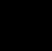

9


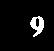

6


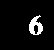

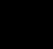

4


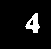

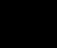

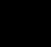

3


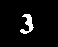

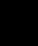

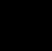

5


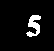

7


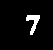

8


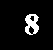

2


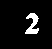

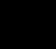

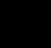

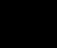

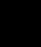

1


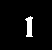

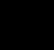

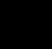

9


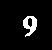

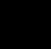

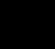

5


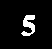

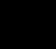

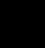

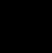

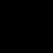

9


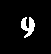

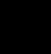

1


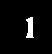

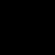

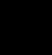

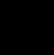

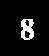

5


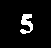

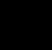

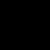

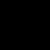

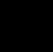

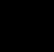

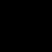

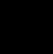

2


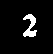

4


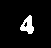

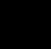

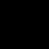

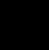

9


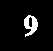

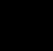

0


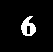

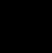

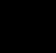

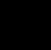

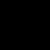

4


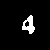

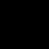

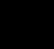

3


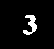

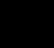

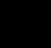

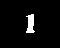

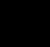

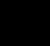

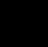

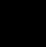

7


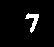

9


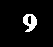

2


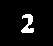

6


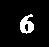

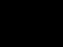

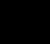

2


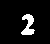

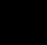

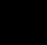

5


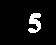

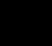

9


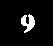

8


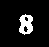

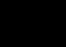

In [ ]:
import pytesseract
# pytesseract.pytesseract.tesseract_cmd = r'/usr/local/bin/pytesseract'
def extract_digit(cell, debug=False):
    # apply automatic thresholding to the cell and then clear any
    # connected borders that touch the border of the cell
    cell_gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(cell_gray, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    # dil_kernel = np.ones((3,3), np.uint8)
    # thresh=cv2.erode(thresh,dil_kernel,iterations=1)
    # check to see if we are visualizing the cell thresholding step
    # if debug:
    #     cv2.imshow("Cell Thresh", thresh)
    #     cv2.waitKey(0)
    return thresh

# cells = boxes

predicted_numbers = []
for i in cells:
    for j,cell in enumerate(cells[i]):
        # cv2_imshow(cell)
        cell_new = extract_digit(cell)
        # cells[i] = cell_new
        cell_new = cv2.cvtColor(cell_new, cv2.COLOR_GRAY2RGB)
        # model_input_cells.append(cv2.resize(cell, (input_size, input_size))/255.0)
        # OCR the input image using Tesseract
        text = pytesseract.image_to_string(cell_new, config="--psm 6 -c tessedit_char_whitelist=0123456789").strip('\n')
        print(text)
        if text == '':
            text=0
            cell_points[i][j][1] = 0
        elif text.isnumeric():
            text=int(text)
            cell_points[i][j][1] = 1
        else:
          cell_points[i][j][1] = 0
        
        if j==8:
            if i==3:
                text=8
            if i==6:
                text=1

        predicted_numbers.append(text)
        
        cv2_imshow(cell_new)

In [ ]:
board_num = np.array(predicted_numbers).reshape(9, 9)
print(predicted_numbers)
print(board_num)

[0, 9, 6, 0, 4, 0, 0, 3, 0, 0, 5, 7, 8, 2, 0, 0, 0, 0, 1, 0, 0, 9, 0, 0, 5, 0, 0, 0, 0, 9, 0, 1, 0, 0, 0, 8, 5, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 4, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 7, 9, 2, 6, 0, 0, 2, 0, 0, 5, 0, 9, 8, 0]
[[0 9 6 0 4 0 0 3 0]
 [0 5 7 8 2 0 0 0 0]
 [1 0 0 9 0 0 5 0 0]
 [0 0 9 0 1 0 0 0 8]
 [5 0 0 0 0 0 0 0 2]
 [4 0 0 0 9 0 0 0 0]
 [0 0 4 0 0 3 0 0 1]
 [0 0 0 0 7 9 2 6 0]
 [0 2 0 0 5 0 9 8 0]]


In [ ]:
inp=[]
def which_box(row_ind, column_ind):
    if row_ind == 0 or row_ind == 1 or row_ind == 2:
        if column_ind == 0 or column_ind == 1 or column_ind == 2:
            return 'box1'
        elif column_ind == 3 or column_ind == 4 or column_ind == 5:
            return 'box2'
        elif column_ind == 6 or column_ind == 7 or column_ind == 8:
            return 'box3'

    elif row_ind == 3 or row_ind == 4 or row_ind == 5:
        if column_ind == 0 or column_ind == 1 or column_ind == 2:
            return 'box4'
        elif column_ind == 3 or column_ind == 4 or column_ind == 5:
            return 'box5'
        elif column_ind == 6 or column_ind == 7 or column_ind == 8:
            return 'box6'

    elif row_ind == 6 or row_ind == 7 or row_ind == 8:
        if column_ind == 0 or column_ind == 1 or column_ind == 2:
            return 'box7'
        elif column_ind == 3 or column_ind == 4 or column_ind == 5:
            return 'box8'
        elif column_ind == 6 or column_ind == 7 or column_ind == 8:
            return 'box9'

def check_in_box(a,b,c,d,elem):
    for i in range(a,b):
        for j in range(c,d):
            if elem == inp[i,j]:
                temp = True
                return temp
            else:
                temp = False
    return temp

def check_box(box,elem):
    if box == 'box1':
        return check_in_box(0,3,0,3,elem)
    if box == 'box2':
        return check_in_box(0,3,3,6,elem)
    if box == 'box3':
        return check_in_box(0,3,6,9,elem)
    if box == 'box4':
        return check_in_box(3,6,0,3,elem)
    if box == 'box5':
        return check_in_box(3,6,3,6,elem)
    if box == 'box6':
        return check_in_box(3,6,6,9,elem)
    if box == 'box7':
        return check_in_box(6,9,0,3,elem)
    if box == 'box8':
        return check_in_box(6,9,3,6,elem)
    if box == 'box9':
        return check_in_box(6,9,6,9,elem)


def search_and_update(row,index,label):
    missing = []
    update = False
    for i in range(1,10):
        if i not in row:
            missing.append(i)
    for i in missing:
        Possible_indices = [h for h,e in enumerate(row) if e == 0]
        iterate = Possible_indices[:]
        pop_count = 0
        for ind, j in enumerate(iterate):
            if label == 'row':
                box = which_box(index,j)
            if label == 'col':
                box = which_box(j,index)
            in_box = check_box(box,i)
            if in_box:
                Possible_indices.pop(ind - pop_count)
                pop_count = pop_count+1
                continue
            if label == 'row':
                if i in inp[:,j]:
                    Possible_indices.pop(ind - pop_count)
                    pop_count = pop_count+1
                    continue
            if label == 'col':
                if i in inp[j,:]:
                    Possible_indices.pop(ind - pop_count)
                    pop_count = pop_count+1
                    continue
        if len(Possible_indices) == 1:
            if label == 'row':
                inp[index,Possible_indices[0]] = i
            if label == 'col':
                inp[Possible_indices[0],index] = i
            update = True
    return update

def sudoku_solve(digits):

    global inp
    inp = digits

    if len(inp) != 81:
        print("Input length is not 81")
        exit(0)

    inp = np.reshape(inp,(9,9))
    done = 0
    condition = 0
    update = False
    first = True

    for m in range(0,100):
    #while not(done):
        row_count = []
        column_count = []
        for i in range(0,9):
            row_count.append(np.count_nonzero(inp[i,:]))
            column_count.append(np.count_nonzero(inp[:,i]))
        #print row_count
        #print column_count

        if update or first:
            row_max = max(row_count)
            col_max = max(column_count)
            if row_max >= col_max:
                index = row_count.index(row_max)
                row = inp[index,:]
                update = search_and_update(row,index,'row')
            else:
                index = column_count.index(col_max)
                col = inp[:,index]
                update = search_and_update(col,index,'col')

        if not(update or first):
            for index, i in enumerate(row_count):
                row = inp[index,:]
                update = search_and_update(row,index,'row')
                if update:
                    break

        if not(update or first):
            for index, i in enumerate(column_count):
                col = inp[:,index]
                update = search_and_update(col,index,'col')
                if update:
                    break

        if np.count_nonzero(inp) == 81:
            done = 1

        check = True
        for i in range(0,9):
            for j in range(1,10):
                if j not in inp[i,:]:
                    check = True and False

        condition = check
        #print condition

        first = False


    out=[val for sublist in inp for val in sublist]
    return out

[[2 9 6 1 4 5 8 3 7]
 [3 5 7 8 2 6 1 4 9]
 [1 4 8 9 3 7 5 2 6]
 [6 3 9 5 1 2 4 7 8]
 [5 8 1 7 6 4 3 9 2]
 [4 7 2 3 9 8 6 1 5]
 [9 6 4 2 8 3 7 5 1]
 [8 1 5 4 7 9 2 6 3]
 [7 2 3 6 5 1 9 8 4]]


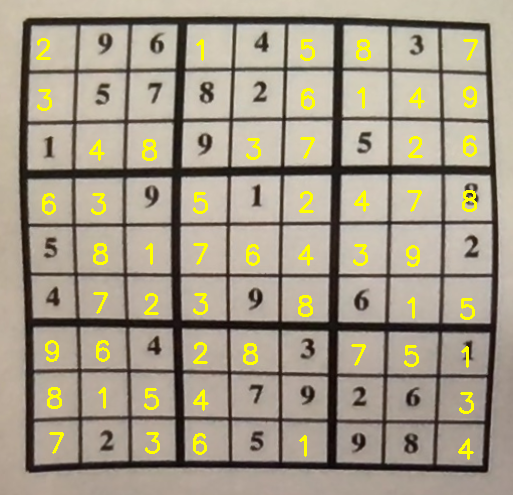

In [ ]:
solved = sudoku_solve(predicted_numbers)
board_num = np.array(solved).reshape(9, 9)
print(board_num)

result_copy = result.copy()

for i in cell_points:
    for j,points in enumerate(cell_points[i]):
        num = board_num[i,j]

        point, present = points
        pt1, pt2 = point
        pt1x, pt1y = pt1
        pt2x, pt2y = pt2

        # compute the coordinates of where the digit will be drawn
        # on the output puzzle image
        textX = int((pt2x - pt1x) * 0.33)
        textY = int((pt2y - pt1y) * -0.2)
        textX += pt1x
        textY += pt2y

        # draw the result digit on the Sudoku puzzle image
        if not present:
            cv2.putText(result_copy, str(num), (textX, textY),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

cv2_imshow(result_copy)

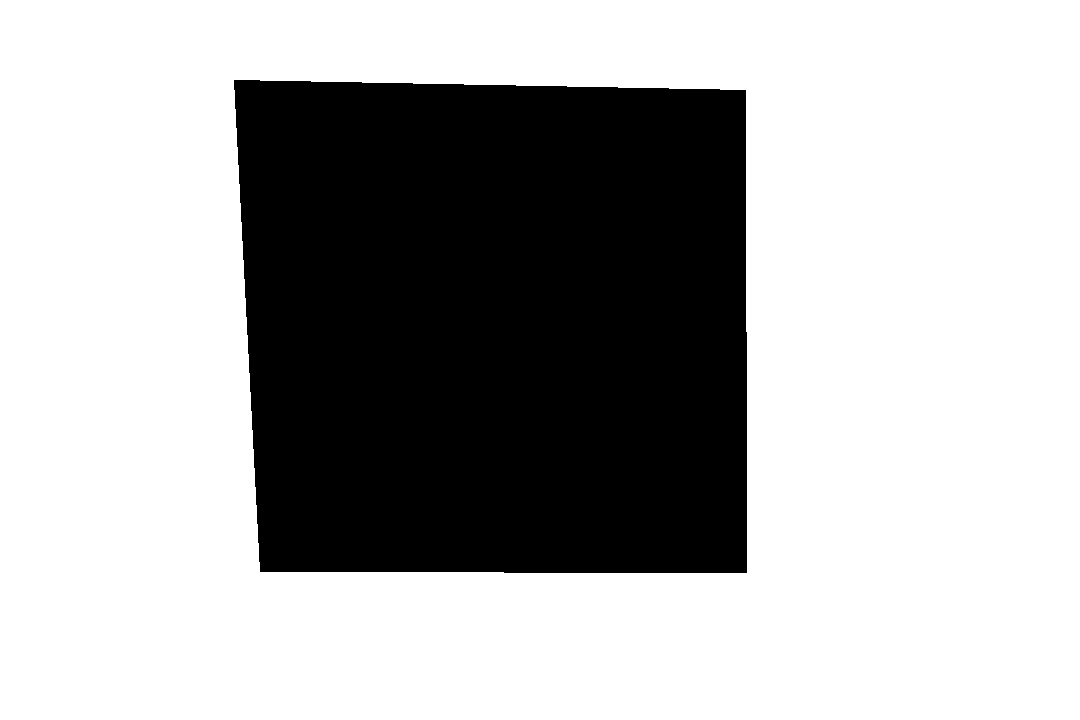

In [ ]:
sudoku_location_mask = np.zeros(img.shape,dtype=np.uint8)
cv2.fillPoly(sudoku_location_mask, [np.array([tl,tr,br,bl])],(255,255,255))
sudoku_location_mask = cv2.bitwise_not(sudoku_location_mask)

cv2_imshow(sudoku_location_mask)

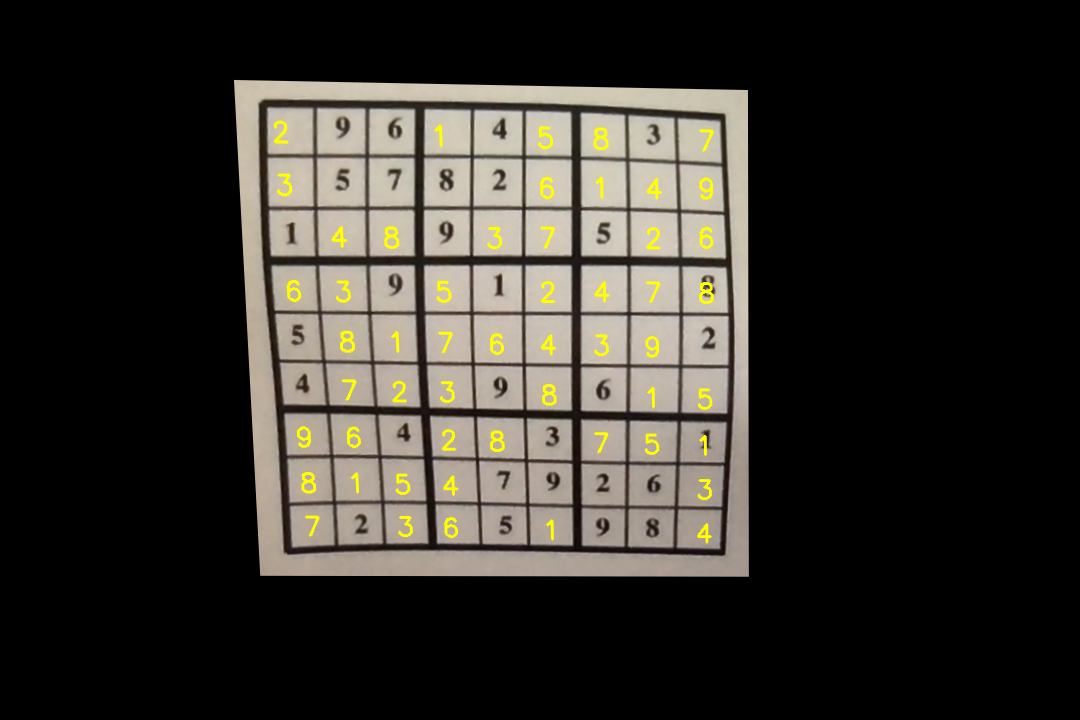

In [ ]:
# # Apply Perspective Transform Algorithm
src = np.array([tl,tr,br,bl], dtype="float32")
matrix_inv = cv2.getPerspectiveTransform(dst, src)
result_mask = cv2.warpPerspective(result_copy, matrix_inv, (img.shape[1],img.shape[0]))

cv2_imshow(result_mask)

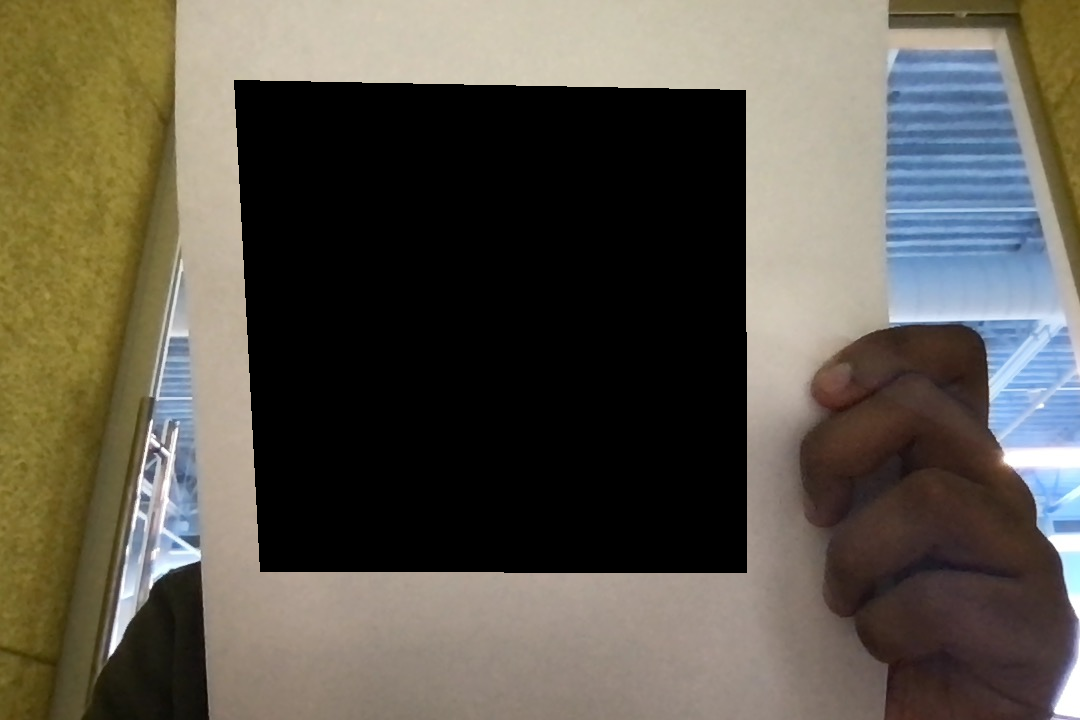

In [ ]:
intermediate_mask = cv2.bitwise_and(sudoku_location_mask,img)

cv2_imshow(intermediate_mask)

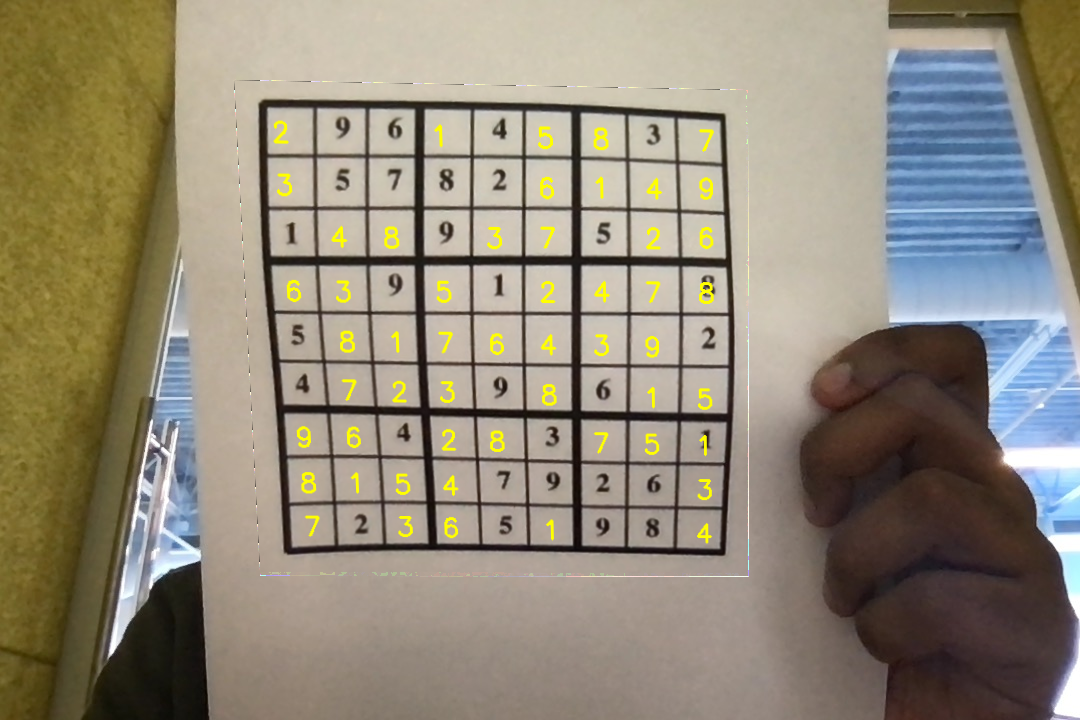

In [ ]:
final_final = cv2.bitwise_or(intermediate_mask,result_mask)

cv2_imshow(final_final)